# Benchmarking FastSwap

2021-12-30

## Data Loading + Cleaning

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
samples = pd.read_csv('samples.csv')

In [3]:
samples.head()

,major_pagefault_latency,minor_pagefault_latency,swap_cache_hits,swapin_count,swapin_prefetch_count
0,13061,2095,1678,500,2083
1,13061,2095,1678,500,2083
2,13061,2095,1678,500,2083
3,13061,2095,1678,500,2083
4,13061,2095,1678,500,2083


In [4]:
samples.dtypes

major_pagefault_latency    int64
minor_pagefault_latency    int64
swap_cache_hits            int64
swapin_count               int64
swapin_prefetch_count      int64
dtype: object

Looks like we got quite a few repeated samples. Maybe we should differentiate them by exporting latencies as a tuple, with a monotonically increasing "timestamp". For now, let's just remove adjacent duplicates and call it a day.

In [5]:
samples.loc[(samples.shift(-1) != samples)['major_pagefault_latency']]

,major_pagefault_latency,minor_pagefault_latency,swap_cache_hits,swapin_count,swapin_prefetch_count
684,13061,2095,1680,515,2097
685,18996,2445,1693,518,2118
686,31988,2584,1707,520,2132
688,34712,700931,1717,521,2139
708,36248,2724,1723,522,2146
...,...,...,...,...,...
21243,37784,1956,142905,86754,181710
21244,33874,2026,142918,86756,181724
21245,35410,2165,142930,86757,181731
21247,35549,3073,142966,86769,181777


Eek, maybe not. Just use the shell tools we're familiar with to take out the more "obvious" repeats. 

In [6]:
uniq_samples = pd.read_csv('uniq_samples.csv')

In [7]:
samples.describe()

,major_pagefault_latency,minor_pagefault_latency,swap_cache_hits,swapin_count,swapin_prefetch_count
count,2.126400e+04,2.126400e+04,21264.000000,21264.000000,21264.000000
mean,3.168014e+04,2.682484e+04,79558.521680,43174.464682,99611.734199
std,1.721975e+05,3.456996e+05,37415.648953,28695.866141,50938.078093
min,4.121000e+03,1.048000e+03,1678.000000,500.000000,2083.000000
25%,8.312000e+03,2.025000e+03,63444.000000,10867.000000,69242.000000
50%,1.857800e+04,2.165000e+03,90855.000000,43798.000000,113070.000000
75%,2.919400e+04,2.375000e+03,106244.000000,70943.000000,140807.000000
max,8.679223e+06,1.292965e+07,142969.000000,86769.000000,181777.000000


In [8]:
uniq_samples.describe()

,major_pagefault_latency,minor_pagefault_latency,swap_cache_hits,swapin_count,swapin_prefetch_count
count,6.669000e+03,6.669000e+03,6669.000000,6669.000000,6669.000000
mean,4.725487e+04,2.757974e+04,75224.424651,40257.622732,93791.768931
std,2.692865e+05,3.302371e+05,42153.605267,31368.437131,56876.819666
min,4.121000e+03,1.048000e+03,1678.000000,500.000000,2083.000000
25%,1.452700e+04,2.026000e+03,34563.000000,5315.000000,35250.000000
50%,2.619000e+04,2.235000e+03,85412.000000,38842.000000,105405.000000
75%,3.135900e+04,2.445000e+03,106373.000000,71696.000000,141067.000000
max,8.679223e+06,1.292965e+07,142969.000000,86769.000000,181777.000000


<AxesSubplot:>

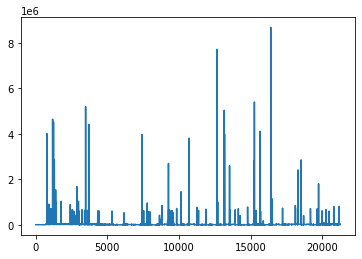

In [9]:
samples['major_pagefault_latency'].plot()

<AxesSubplot:>

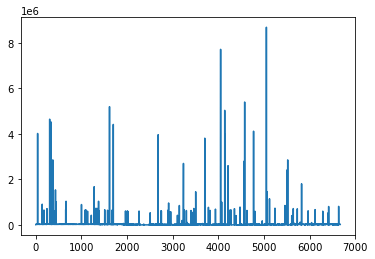

In [10]:
uniq_samples['major_pagefault_latency'].plot()

Looked through the raw data. I think that the best way to interpret at this should be by extracting individual columns, and visualizing those. I'll assume that the swap latency and pagefault latency aren't too correlated. 

## Data Analysis

### Visualizing Swap Latencies

In [11]:
# Deduplicate adjacent samples. 
def dedup_adjacent(df, column):
    series = df[column]
    return series.loc[series.shift() != series]

# Trim the outliers of a Pandas series (used for plotting)
def trim_outliers(S): 
    return S[~((S-S.mean()).abs() > 3*S.std())]

In [40]:
major_latencies = dedup_adjacent(samples, 'major_pagefault_latency')
minor_latencies = dedup_adjacent(samples, 'minor_pagefault_latency')
#ax.hist(dedup_adjacent(samples, 'minor_pagefault_latency'),
#          label='Minor Page Fault Latencies')

In [41]:
major_latencies.describe()

count    4.946000e+03
mean     5.109180e+04
std      2.996591e+05
min      4.121000e+03
25%      1.501600e+04
50%      2.667900e+04
75%      3.169075e+04
max      8.679223e+06
Name: major_pagefault_latency, dtype: float64

In [43]:
minor_latencies.describe()

count    4.477000e+03
mean     3.297604e+04
std      3.771559e+05
min      1.048000e+03
25%      2.026000e+03
50%      2.235000e+03
75%      2.514000e+03
max      1.292965e+07
Name: minor_pagefault_latency, dtype: float64

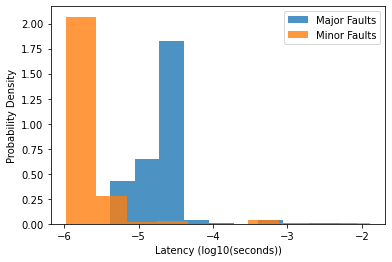

In [36]:
log_major_latencies = np.log10(major_latencies / 1e9)
log_minor_latencies = np.log10(minor_latencies / 1e9)

fig, ax = plt.subplots(1)

ax.hist(log_major_latencies, label='Major Faults', density=True, alpha=0.8)
ax.hist(log_minor_latencies, label='Minor Faults', density=True, alpha=0.8)


ax.set_ylabel('Probability Density')
ax.set_xlabel('Latency (log10(seconds))')
ax.legend()

fig.savefig('fault-latency-hist.png', dpi=600)

Good stuff!

### Calculating Swap Prefetch Contribution

Look as late as possible in the dataset, because we'll have averaged more data. 

In [38]:
swap_cache_hits = 142969
swapin_count = 86769
swapin_prefetch_count = 181777

prefetch_contribution = swapin_prefetch_count / (swapin_count + swapin_prefetch_count)
prefetch_accuracy = swap_cache_hits / swapin_prefetch_count

In [39]:
print(prefetch_contribution, prefetch_accuracy)

0.6768933441570532 0.7865076439813617


Good stuff. Can experiment with other applications as needed. 